# Imports
Mount google drive drisk with notebook, import libraries we need

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
from keras.applications.vgg16 import VGG16

from PIL import Image

import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
import os
import sys
import random
import warnings
from sklearn.model_selection import train_test_split

import keras

from keras import backend as K
from keras.optimizers import Adam
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization, Input
from keras.layers import Dropout, GlobalAveragePooling2D

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, Input, ZeroPadding2D, BatchNormalization, Activation, Add, AveragePooling2D
from keras.initializers import glorot_normal

from keras.callbacks import Callback, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import shutil
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.applications.resnet50 import ResNet50

from keras.models import model_from_json


Using TensorFlow backend.


# Classification

## Model

### Constants
Some constants usefull for model

In [0]:
np.random.seed(7)

start = dt.datetime.now()

BATCH_SIZE = 16
EPOCHS = 20

NUM_CLASSES = 7
IMAGE_SIZE = 256

IMAGE_SIZE_FULL_RESNET50 = 224

# Increasing recursion limit to reach files deep in directories
sys.setrecursionlimit(3000)

In [5]:
working_path = "/content/drive/My Drive/Dog_Breed/7_breeds/"
!ls "/content/drive/My Drive/Dog_Breed/7_breeds/models/ResNet50_300/"


ResNet50_300+100+400_acc.png   ResNet50_300+100_acc.png   ResNet50_300_acc.png
ResNet50_300+100+400.h5        ResNet50_300+100.h5	  ResNet50_300.h5
ResNet50_300+100+400_loss.png  ResNet50_300+100_loss.png  ResNet50_300_loss.png


### Preprocess
Change images size according to constants we've set, build and train ImageDataGenerators for data augmentations

In [5]:
labels = pd.read_csv(working_path + 'data/256_labels.csv')
breeds = np.unique(labels['class'])
breed_dictionary = {} 
for i in range(len(breeds)):
    breed_dictionary[i] = breeds[i]

breed_dictionary

{0: 'German_shepherd',
 1: 'Labrador_retriever',
 2: 'Rottweiler',
 3: 'Yorkshire_terrier',
 4: 'beagle',
 5: 'pug',
 6: 'standard_poodle'}

In [0]:
def preprocess(img):
    img = cv2.resize(img, 
        (IMAGE_SIZE, IMAGE_SIZE), 
        interpolation = cv2.INTER_AREA)

    img_1 = image.img_to_array(img)
    img_1 = cv2.resize(img_1, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_AREA)
    img_1 = np.expand_dims(img_1, axis=0) / 255.

    return img_1[0]

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=30,
    width_shift_range=0.3, 
    height_shift_range=0.3,
    horizontal_flip=True,  
    vertical_flip=False,
    zoom_range=0.3)

# we do not want to augment our validation dataset, want to keep it as real as possible
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess)

train_gen = train_datagen.flow_from_directory(
    working_path + "data/train/", 
    batch_size=BATCH_SIZE, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    shuffle=True,
    class_mode="categorical")

val_gen = val_datagen.flow_from_directory(
    working_path + "data/valid/", 
    batch_size=BATCH_SIZE, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    shuffle=True,
    class_mode="categorical")

Found 846 images belonging to 7 classes.
Found 369 images belonging to 7 classes.


### Model 

#### Vanilla
Simple CNN architecture - easy to reach gradient vanishing

In [0]:
def Vanilla():
    model = Sequential()

  # Note the (7, 7) here. This is one of technics 
  # used to reduce memory use by the NN: we scan
  # the image in a larger steps.
  # Also note regularizers.l2: this technic is 
  # used to prevent overfitting. The "0.001" here
  # is an empirical value and can be optimized.
    model.add(Conv2D(16, (7, 7), padding='same', use_bias=False, 
                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
                     kernel_regularizer=regularizers.l2(0.001)))

  # Note the use of a standard CNN building blocks: 
  # Conv2D - BatchNormalization - Activation
  # MaxPooling2D - Dropout
  # The last two are used to avoid overfitting, also,
  # MaxPooling2D reduces memory use.
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(1, 1), padding='same'))
    model.add(Dropout(0.5))
  
    model.add(Conv2D(32, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
  
    model.add(Conv2D(32, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(1, 1), padding='same'))
    model.add(Dropout(0.5))
  
    model.add(Conv2D(64, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(1, 1), padding='same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(1, 1), padding='same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(256, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
  
    model.add(Conv2D(256, (3, 3), padding='same', 
                     use_bias=False, 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(1, 1), padding='same'))
    model.add(Dropout(0.5))
  
  # This is the end on "convolutional" part of CNN. 
  # Now we need to transform multidementional
  # data into one-dim. array for a fully-connected
  # classifier:
    model.add(Flatten())
  # And two layers of classifier itself (plus an 
  # Activation layer in between):
    model.add(Dense(NUM_CLASSES, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Activation("relu"))
    model.add(Dense(NUM_CLASSES, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.01)))

  # We need to compile the resulting network. 
  # Note that there are few parameters we can
  # try here: the best performing one is uncommented, 
  # the rest is commented out for your reference.
  #model.compile(optimizer='rmsprop', 
  #    loss='categorical_crossentropy', 
  #    metrics=['accuracy'])
  #model.compile(
  #    optimizer=keras.optimizers.RMSprop(lr=0.0005), 
  #    loss='categorical_crossentropy', 
  #    metrics=['accuracy'])
  
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
  #model.compile(optimizer='adadelta', 
  #    loss='categorical_crossentropy', 
  #    metrics=['accuracy'])
  
  #opt = keras.optimizers.Adadelta(lr=1.0, 
  #    rho=0.95, epsilon=0.01, decay=0.01)
  #model.compile(optimizer=opt, 
  #    loss='categorical_crossentropy', 
  #    metrics=['accuracy'])
  
  #opt = keras.optimizers.RMSprop(lr=0.0005, 
  #    rho=0.9, epsilon=None, decay=0.0001)
  #model.compile(optimizer=opt, 
  #    loss='categorical_crossentropy', 
  #    metrics=['accuracy'])
  
  # model.summary()

    return model

#### ResNet50 pretrained 
Load pretrained ResNet50 model from library

In [0]:
# 95 acc, 30epoch, retrain on top layers

def ResNet50_train_top():
  base_model = ResNet50(weights='imagenet', 
	include_top=False, pooling='avg', 
	input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

  x = base_model.output
  x = Dense(512)(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)
		  
  predictions = Dense(NUM_CLASSES, 
	activation='softmax')(x)

  model = Model(inputs=base_model.input, 
	outputs=predictions)

  #model.layers[0].trainable = False
			  
#  model.compile(loss='categorical_crossentropy', 
#	optimizer='adam', metrics=['accuracy'])
  model.compile(optimizer='sgd', 
	loss='categorical_crossentropy', 
	metrics=['accuracy']) 

  #model.summary()            
		  
  return model

#### ResNet50 
Build ResNet architecture from scrach, compile and train it from beginning

In [0]:
def identity_block(X, f, filters, stage, block):
    # names
    conv_name = 'res' + str(stage) + block + 'branch'
    bn_name = 'bn' + str(stage) + block + 'branch'
    
    # filters
    F1, F2, F3 = filters
    
    # input value to add in the end
    X_skip = X
    
    # main path block 1
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name + '2a', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2a')(X)
    X = Activation('relu')(X)
    
    # main path block 2
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name + '2b',  kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2b')(X)
    X = Activation('relu')(X)    
    
    # main path block 3
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name + '2c', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2c')(X)
    
    # add skip connection with main path
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    return X
  
def convolutional_block(X, f, filters, stage, block, s = 2):
    # names
    conv_name = 'res' + str(stage) + block + 'branch'
    bn_name = 'bn' + str(stage) + block + 'branch'
    
    # filters
    F1, F2, F3 = filters  
  
    # input value to add in the end
    X_skip = X  
  
    # main path block 1
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name + '2a', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2a')(X)
    X = Activation('relu')(X)  

    # main path block 2
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name + '2b',  kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2b')(X)
    X = Activation('relu')(X)      
  
    # main path block 3
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name + '2c', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2c')(X) 
  
    # skip path
    X_skip = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name + '1',  kernel_initializer=glorot_normal(seed=0))(X_skip)
    X_skip = BatchNormalization(axis=3, name=bn_name + '1')(X_skip)
    
    # add skip connection with main path
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    return X


def ResNet50_scrach():
    
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    classes = 7
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    X = GlobalAveragePooling2D('channels_last', name='global_avg_pool')(X)
    
    # output layers
    #X = Flatten()(X)

    X = Dense(512)(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    
    model.compile(optimizer='sgd', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 
    
    return model

#### Base model

In [0]:
def identity_block_base(X, f, filters, stage, block):
    # names
    conv_name = 'res' + str(stage) + block + 'branch'
    bn_name = 'bn' + str(stage) + block + 'branch'
    
    # filters
    F1, F2, F3 = filters
    
    # input value to add in the end
    X_skip = X
    
    # main path block 1
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name + '2a', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2a')(X)
    X = Activation('relu')(X)
    
    # main path block 2
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name + '2b',  kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2b')(X)
    X = Activation('relu')(X)    
    
    # main path block 3
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name + '2c', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2c')(X)
    
    # add skip connection with main path
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    return X
  
def convolutional_block_base(X, f, filters, stage, block, s = 2):
    # names
    conv_name = 'res' + str(stage) + block + 'branch'
    bn_name = 'bn' + str(stage) + block + 'branch'
    
    # filters
    F1, F2, F3 = filters  
  
    # input value to add in the end
    X_skip = X  
  
    # main path block 1
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name + '2a', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2a')(X)
    X = Activation('relu')(X)  

    # main path block 2
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name + '2b',  kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2b')(X)
    X = Activation('relu')(X)      
  
    # main path block 3
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name + '2c', kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name + '2c')(X) 
  
    # skip path
    X_skip = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name + '1',  kernel_initializer=glorot_normal(seed=0))(X_skip)
    X_skip = BatchNormalization(axis=3, name=bn_name + '1')(X_skip)
    
    # add skip connection with main path
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    return X


def ResNet50_base(classes):
    
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  
    # Stage 2
    X = convolutional_block_base(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block_base(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block_base(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block_base(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block_base(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block_base(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block_base(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block_base(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block_base(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block_base(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block_base(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block_base(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block_base(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block_base(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block_base(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block_base(X, 3, [512, 512, 2048], stage=5, block='c')
    
    return X

In [0]:
def classifier_layer(X, num_classes):
#   input_shape = (8, 8, 2048)
  X_input = Input(256,256,3)
  
  # AVGPOOL
  X = GlobalAveragePooling2D('channels_last', name='global_avg_pool')(X)

  X = Dense(512)(X)
  X = Activation('relu')(X)
  X = Dropout(0.5)(X)
    
  X_class = Dense(num_classes, activation='softmax', name='fc' + str(classes), kernel_initializer='zero')(X)
  
  return X_class

#   X_regr = Dense(4 * (num_classes-1), activation='linear', kernel_initializer='zero')
#   return [X_class, X_regr]

### Model info
Some model architectures info

In [65]:
model = ResNet50_scrach()
print('Number of layers: ', len(model.layers))
print('------------------------------------------------------------')
model.summary()

Number of layers:  180
------------------------------------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 262, 262, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
_________________________

In [55]:
model = ResNet50_train_top()
print('Number of layers: ', len(model.layers))
print('------------------------------------------------------------')
model.summary()

Number of layers:  180
------------------------------------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
_________________________

## Train

### Compile from scrach model
Comment following cell when loading model from disk

In [0]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

In [0]:
# train_model = ResNet50_scrach()

### Compile pretrained from disk
Comment following cell when training from beginning with models described in this notebook above

In [0]:
loaded_model = model_from_drive('models/ResNet50_300/ResNet50_300+100+400.h5')
loaded_model_weights = loaded_model.get_weights()

train_model = ResNet50_scrach()
train_model.set_weights(loaded_model_weights)

### Fit

In [59]:
history = train_model.fit_generator(generator=train_gen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_gen,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=400)

Epoch 1/400
52/52 [==============================] - 43s 826ms/step - loss: 0.1611 - acc: 0.9543 - val_loss: 3.4632 - val_acc: 0.4363
Epoch 2/400
52/52 [==============================] - 32s 612ms/step - loss: 0.2034 - acc: 0.9322 - val_loss: 2.0076 - val_acc: 0.5581
Epoch 3/400
52/52 [==============================] - 32s 613ms/step - loss: 0.1852 - acc: 0.9361 - val_loss: 2.3609 - val_acc: 0.5779
Epoch 4/400
52/52 [==============================] - 32s 614ms/step - loss: 0.2038 - acc: 0.9263 - val_loss: 2.0583 - val_acc: 0.5609
Epoch 5/400
52/52 [==============================] - 32s 611ms/step - loss: 0.1723 - acc: 0.9394 - val_loss: 2.3375 - val_acc: 0.5552
Epoch 6/400
52/52 [==============================] - 32s 613ms/step - loss: 0.1595 - acc: 0.9518 - val_loss: 1.6785 - val_acc: 0.6232
Epoch 7/400
52/52 [==============================] - 32s 613ms/step - loss: 0.1544 - acc: 0.9518 - val_loss: 2.6019 - val_acc: 0.5156
Epoch 8/400
52/52 [==============================] - 32s 613ms

### Save

In [0]:
save_model(train_model, model_name = 'resnet.h5', folder_name = 'models/ResNet50_300/')

### Plot

In [0]:
plot_history(True, train_model, folder_name = 'models/ResNet50_300/', img_name = 'resnet')

##Test

In [192]:
j = 0
for file_name in os.listdir(working_path + "data/test/"):
	img = image.load_img(working_path + "data/test/" + file_name);

	img_1 = image.img_to_array(img)
	img_1 = cv2.resize(img_1, (IMAGE_SIZE, IMAGE_SIZE), 
		interpolation = cv2.INTER_AREA)
	img_1 = np.expand_dims(img_1, axis=0) / 255.

	y_pred = train_model.predict(img_1)

	# get 5 best predictions
	y_pred_ids = y_pred[0].argsort()[-5:][::-1]

	print(file_name)
	for i in range(len(y_pred_ids)):
		print("\n\t" + breed_dictionary[y_pred_ids[i]]
			+ " (" 
			+ str(y_pred[0][y_pred_ids[i]]) + ")")

	print("--------------------\n")

	j = j + 1

beagle.jpg

	beagle (1.0)

	German_shepherd (6.681615e-13)

	Labrador_retriever (5.3549103e-13)

	pug (1.3439683e-13)

	Rottweiler (6.9247566e-14)
--------------------

Yorkshire_terrier.jpg

	Yorkshire_terrier (0.998437)

	German_shepherd (0.0012143932)

	beagle (0.00034048577)

	pug (7.179968e-06)

	Labrador_retriever (9.256487e-07)
--------------------

Labrador_retriever.jpg

	German_shepherd (0.52900016)

	pug (0.25237232)

	Yorkshire_terrier (0.09541196)

	beagle (0.0714587)

	Rottweiler (0.030620309)
--------------------

German_shepherd.jpg

	German_shepherd (0.99984765)

	pug (0.00015029685)

	Rottweiler (9.59514e-07)

	Labrador_retriever (5.714829e-07)

	beagle (5.3331553e-07)
--------------------

pug.jpg

	pug (1.0)

	Rottweiler (2.5658957e-09)

	beagle (8.423335e-12)

	Labrador_retriever (4.9307776e-12)

	German_shepherd (3.634722e-12)
--------------------

standard_poodle.jpg

	standard_poodle (0.99940836)

	German_shepherd (0.0002453238)

	Labrador_retriever (0.000129454

# Functions

## Plot
Plotting training process history: accuracy, loss for both - training and validation sets, saving plots to disk

In [0]:
def plot_history(save, history, folder_name, img_name):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['acc', 'val_acc'], loc='upper left')
  if save:
    plt.savefig(working_path + folder_name + img_name + '_acc.png', bbox_inches='tight')
    print('Image have been saved.')
  plt.show()


  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  if save:
    plt.savefig(working_path + folder_name + img_name + '_loss.png', bbox_inches='tight')
    print('Image have been saved.')
  plt.show()


## Save model
Save trained model to disk

In [0]:
def save_model(model, model_name, folder_name):
  model.save(working_path + folder_name + model_name)
  print('Saved model')

## Load model

In [0]:
def model_from_drive(model_path):
  model = load_model(working_path + model_path)
  return model

# Regression

## Load, compile model

In [10]:
loaded_model = model_from_drive('models/ResNet50_300/ResNet50_300+100+400.h5')
loaded_model_weights = loaded_model.get_weights()

train_model = ResNet50_scrach()
train_model.set_weights(loaded_model_weights)

W0812 07:45:21.097849 140619089725312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 07:45:21.189027 140619089725312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 07:45:21.234680 140619089725312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 07:45:21.236083 140619089725312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 07:45:21.238699 140619089

In [11]:
X_regr = Dense(4, activation='linear')(train_model.layers[-5].output)

regr_model = Model(input = train_model.input, output = X_regr)

opt = Adam(lr=0.0001)
regr_model.compile(optimizer=opt, loss="mse", metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# regr_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Freeze shared layers

In [12]:
# for layer in regr_model.layers[:-1]:
#     layer.trainable = False
    
for layer in regr_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe3c362b400> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe415105898> True
<keras.layers.convolutional.Conv2D object at 0x7fe413090f28> True
<keras.layers.normalization.BatchNormalization object at 0x7fe4130a9c88> True
<keras.layers.core.Activation object at 0x7fe4130a9ba8> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe412e4e320> True
<keras.layers.pooling.MaxPooling2D object at 0x7fe412e32a90> True
<keras.layers.convolutional.Conv2D object at 0x7fe412dfbe80> True
<keras.layers.normalization.BatchNormalization object at 0x7fe412e37748> True
<keras.layers.core.Activation object at 0x7fe412e37f98> True
<keras.layers.convolutional.Conv2D object at 0x7fe3c0b8f358> True
<keras.layers.normalization.BatchNormalization object at 0x7fe3c0beb7b8> True
<keras.layers.core.Activation object at 0x7fe3c0aed2b0> True
<keras.layers.convolutional.Conv2D object at 0x7fe3c0a56e48> True
<keras.layers.convolutional.Conv2D obj

## Prepare dataset

In [13]:
img_path = working_path + 'all_images/'
dirs = os.listdir(img_path)

img_list = []
for img in dirs:
  img = cv2.imread(img_path + img)
  img_1 = image.img_to_array(img)
  img_1 = cv2.resize(img_1, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_AREA)
  img_1 = img_1/.255
  img_list.append(img_1)

X_train = np.array(img_list)
X_train.shape


(1193, 256, 256, 3)

In [14]:
full_labels = pd.read_csv(working_path + 'data/256_labels.csv')
full_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,x_koef,y_koef,xmin_resized,ymin_resized,xmax_resized,ymax_resized,xmin_new,ymin_new,xmax_new,ymax_new
0,n02088364_10108,375,500,beagle,75,56,281,498,1.464844,1.953125,51.200000,28.672000,191.829333,254.976000,51,29,192,255
1,n02088364_10206,500,400,beagle,76,99,464,377,1.953125,1.562500,38.912000,63.360000,237.568000,241.280000,39,63,238,241
2,n02088364_10296,500,375,beagle,240,140,499,368,1.953125,1.464844,122.880000,95.573333,255.488000,251.221333,123,96,255,251
3,n02088364_10354,500,375,beagle,30,54,458,374,1.953125,1.464844,15.360000,36.864000,234.496000,255.317333,15,37,234,255
4,n02088364_10362,335,199,beagle,165,22,331,188,1.308594,0.777344,126.089552,28.301508,252.943284,241.849246,126,28,253,242


In [15]:
Y_train = []

for img_name in dirs:
  img = img_name.split('.')
  row = full_labels.loc[full_labels['filename'] == img[0]]
  for index, row in row.iterrows():
    x1 = row['xmin_new']
    y1 = row['ymin_new']
    x2 = row['xmax_new']
    y2 = row['ymax_new']
    nump_array = ([x1, y1, x2, y2])
  Y_train.append(nump_array)

Y_train = np.asarray(Y_train)
Y_train.shape  

(1193, 4)

In [0]:
random.seed(30)
random.shuffle([X_train, Y_train])

In [17]:
print(X_train.shape)
print(Y_train.shape)

print(type(X_train))
print(type(Y_train))

(1193, 256, 256, 3)
(1193, 4)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Fit

In [18]:
regr_history = regr_model.fit(
    X_train, Y_train, epochs=100, verbose=1, validation_split=0.3)

Train on 835 samples, validate on 358 samples
Epoch 1/100
835/835 [==============================] - 47s 57ms/step - loss: 24624.9201 - acc: 0.5808 - val_loss: 9025.6148 - val_acc: 0.6676
Epoch 2/100
835/835 [==============================] - 31s 37ms/step - loss: 20086.0688 - acc: 0.6455 - val_loss: 9974.8747 - val_acc: 0.5475
Epoch 3/100
835/835 [==============================] - 31s 37ms/step - loss: 17861.0382 - acc: 0.6455 - val_loss: 11855.9241 - val_acc: 0.5251
Epoch 4/100
835/835 [==============================] - 30s 36ms/step - loss: 16133.0508 - acc: 0.6455 - val_loss: 15411.7998 - val_acc: 0.6620
Epoch 5/100
835/835 [==============================] - 31s 37ms/step - loss: 14614.7516 - acc: 0.6479 - val_loss: 9721.2163 - val_acc: 0.5978
Epoch 6/100
835/835 [==============================] - 31s 37ms/step - loss: 13205.8359 - acc: 0.6455 - val_loss: 5543.1776 - val_acc: 0.4916
Epoch 7/100
835/835 [==============================] - 31s 37ms/step - loss: 11929.1609 - acc: 0.645

## Plot

Image have been saved.


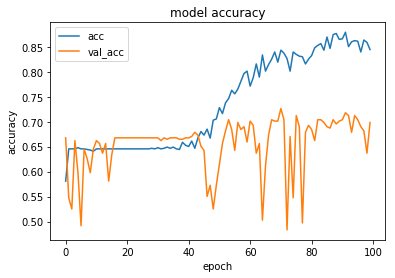

Image have been saved.


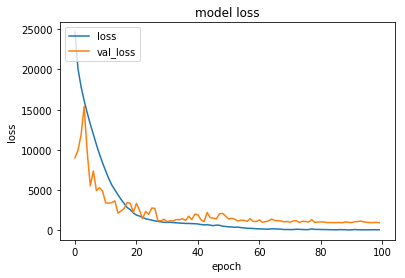

In [19]:
plot_history(True, regr_history, folder_name = 'models/Regression/', img_name = 'regression_15+100')

## Save

In [20]:
save_model(regr_model, model_name = 'regression_115.h5', folder_name = 'models/Regression/')

Saved model


## Clear session

In [0]:
K.clear_session()